Imports


In [1]:
import json
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
import ssl
from sklearn.feature_extraction.text import CountVectorizer
import hdbscan
import pickle as pk

C:\Users\diego\anaconda3\envs\TF-Keras\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


utils

In [2]:
def loadPickle(path):
    with open(path, "rb") as output_file:
        return pk.load(output_file)

def savePickle(variable, path):
    with open(path, "wb") as umap_file:
        pk.dump(variable, umap_file)

In [3]:
prefix = './datasets/'
spanish_path = prefix + 'spanish/spanish_hash.json'

# Todo lo siguiente por motivos de performance fueron calculados en el HPC
#Los scripts correspondientes están en la carpeta de HPC
umap_path = prefix + 'spanish/umap_es_v2.pickle'
embbedings_path = prefix + 'spanish/embeddings_es_v2.pickle'
umap_graph_path = prefix + 'spanish/umap_es_graph.pickle'
hdbscan_output_graph = prefix + 'spanish/hdbscan_es_graph.pickle'


In [4]:
file = open(spanish_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
spanish_raw = pd.json_normalize(data)

print(spanish_raw.shape)
spanish_raw.head(10)

(845125, 4)


,id,publication_date,source,text
0,1304391319972790274,1.599826e+09,twitter,ORACIÓN DIARIAViernes 11 de Septiembre 2020#or...
1,1308823479077175297,1.600883e+09,twitter,Se pudrió todo. Acá la FIFA debe castigar a la...
2,1255929719893221377,1.588272e+09,twitter,Última Publicación en la Prensaldia - @ca...
3,1367024221319286784,1.614759e+09,twitter,Australia = 0 positivos por coronavirus.¿Vacun...
4,1278689023087849480,1.593698e+09,twitter,coronavirus esto ya es personal
5,1374234992969015297,1.616478e+09,twitter,"#LadyZopilota, zopiloteando en la noticia."
6,1296604758732570625,1.597970e+09,twitter,La noticia que esperaban los mercados. Gracias...
7,1344926278592438272,1.609490e+09,twitter,No caigamos en la trampa.En México ya iniciaro...
8,1311046706809786372,1.601413e+09,twitter,El coronavirus se ha confirmado ya en más de 2...
9,1257004539875667971,1.588528e+09,twitter,@JaimeChincha @RPPNoticias Mi padre acaba de m...


In [5]:
'''
Turn text to Numpy Array
'''
texts_column = spanish_raw.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'ORACIÓN DIARIAViernes 11 de Septiembre 2020#oraciondiaria #11DeSeptiembre #BuenosDias #BuenosDiasATodos… '

Implementación de Arquitectura


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
embeddings = model.encode(raw_texts, show_progress_bar=True)

In [6]:
from sentence_transformers import SentenceTransformer
embeddings = loadPickle(umap_path)

### UMAP para reducir la dimensionalidad de los embeddings
#### Esto permite una mejor clasificación para el clustering

In [ ]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

Load Umap Embbedings

In [7]:
import umap.umap_ as umap
umap_embeddings = loadPickle(umap_path)

### HDBSCAN para el clustering

In [8]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          min_samples = 480,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
cluster = loadPickle(hdbscan_output)


c-TfIdf

In [9]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [10]:
from stop_words import get_stop_words
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=get_stop_words("spanish")).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [11]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
4,3,840198
0,-1,2330
2,1,1491
1,0,559
3,2,547


In [12]:
print(len(topic_sizes['Topic']))
for topic in topic_sizes['Topic'][:10]:
  if topic == -1:
    continue
  print('Topic #' + str(topic) +":"+ '\n')
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')

5
Topic #3:

['coronavirus', 'covid', '19', 'covid19', 'casos', 'si', 'nuevos', 'pandemia', 'salud', 'vacuna']

Topic #1:

['israel', 'israelí', 'coronavirus', 'israelíes', 'palestina', 'covid', '19', 'vacuna', 'netanyahu', 'palestinos']

Topic #0:

['totales', '0muertes', '0recuperados', 'nuevos', '2020casos', 'contagiados', 'reporte', 'nuevas', 'hoy', '2021casos']

Topic #2:

['irán', 'iraní', 'coronavirus', 'iran', 'muertos', 'iraníes', 'viceministro', '000', '19', 'covid']



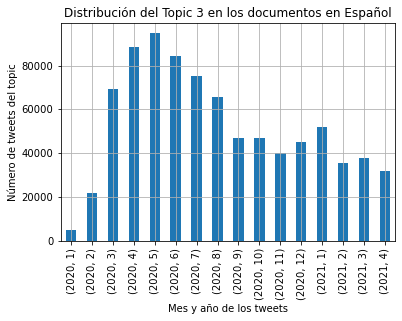

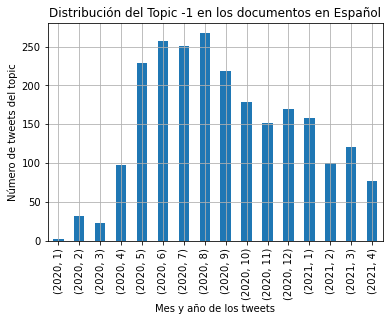

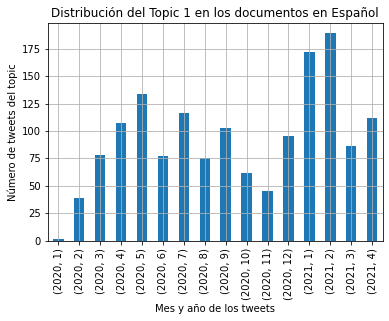

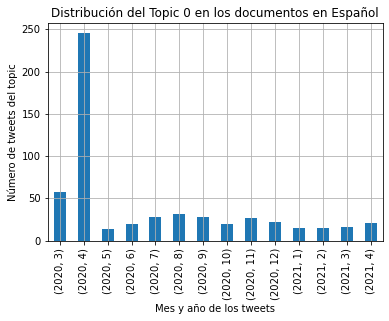

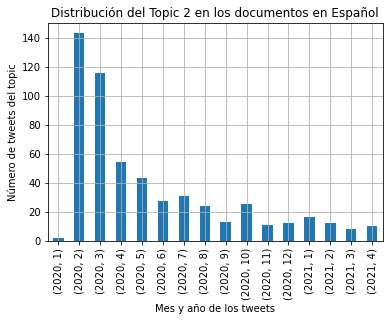

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime

spanish_raw['dates'] =  spanish_raw['publication_date'].apply(lambda x:  datetime.fromtimestamp(x))
spanish_raw['Topic'] = cluster.labels_
spanish_raw


for num_topic in topic_sizes['Topic'][:10]:
    ax = spanish_raw.groupby([spanish_raw['Topic'], spanish_raw['dates'].dt.year, spanish_raw['dates'].dt.month]).count()['id'][num_topic].plot(kind="bar") #Imprime el topic cero
    ax.grid(b=True, axis='both')
    #print(type(ax))
    ax.set_title('Distribución del Topic ' + str(num_topic) + ' en los documentos en Español')
    ax.set_xlabel('Mes y año de los tweets')
    ax.set_ylabel('Número de tweets del topic')
    plt.show()

# Other params for DBScan

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          min_samples = 300,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
savePickle(cluster, hdbscan_output_graph)

In [4]:
cluster = loadPickle(hdbscan_output_graph)

### Visualisación de los clusters


In [8]:
import matplotlib.pyplot as plt

# Prepare data
# umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
umap_data = loadPickle(umap_graph_path)
print('umap embedding loaded')
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

umap embedding loaded


# Visualize clusters

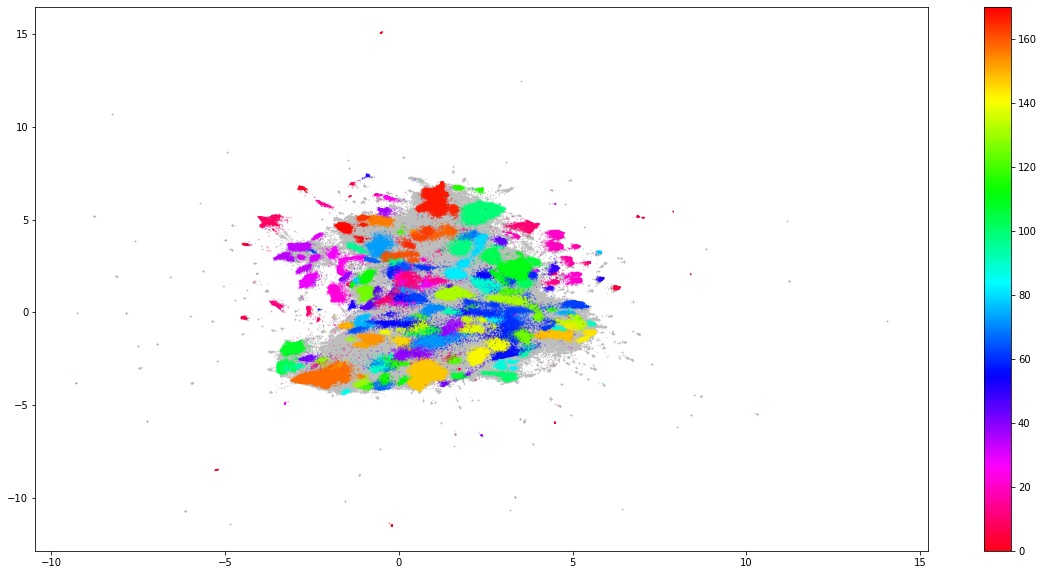

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != 1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Print results

In [14]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [19]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
0,-1,576636
100,99,19741
168,167,14988
111,110,12908
148,147,12540
159,158,9798
126,125,5827
23,22,5606
133,132,5196
12,11,5178


In [20]:
print(len(topic_sizes['Topic']))
for topic in topic_sizes['Topic'][:10]:
  if topic == -1:
    continue
  print('Topic #' + str(topic) +":"+ '\n')
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')


172
Topic #99:

['coronavirus', 'si', 'va', 'ahora', 'gente', 'peor', 'creo', 'solo', 'ser', 'hace']

Topic #167:

['coronavirus', 'si', 'voy', 'mata', 'gente', 'va', 'quiero', 'ahora', 'matar', 'ver']

Topic #110:

['vacuna', '19', 'covid', 'vacunas', 'vacunación', 'covid19', 'dosis', 'méxico', 'pfizer', 'astrazeneca']

Topic #147:

['si', 'lopezobrador_', 'hlgatell', 'aquí', 'ivanduque', 'bien', 'hola', 'mira', 'nicolasmaduro', 'ver']

Topic #158:

['bien', 'si', 'bueno', 'vamos', 'así', 'pues', 'siempre', 'va', 'mierda', 'ahí']

Topic #125:

['positivo', 'covid', '19', 'dio', 'da', 'jugadores', 'fútbol', 'liga', 'positivos', 'covid19']

Topic #22:

['madrid', 'comunidad', 'ayuso', 'madrileños', 'coronavirus', 'españa', 'madri', 'gobierno', 'covid', 'covid19']

Topic #132:

['médicos', 'salud', 'médico', 'hospital', 'hospitales', 'personal', 'sistema', 'doctor', 'si', 'enfermeras']

Topic #11:

['trump', 'biden', 'donald', 'presidente', 'joe', 'coronavirus', 'covid', '19', 'eeuu', 'u